### Name: C. J. Kurukulasuriya
### Index No.: 190337X

### Prerequisites

In [1]:
import numpy as np
import sympy as sy
import matplotlib.pyplot as plt
import cv2 as cv
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

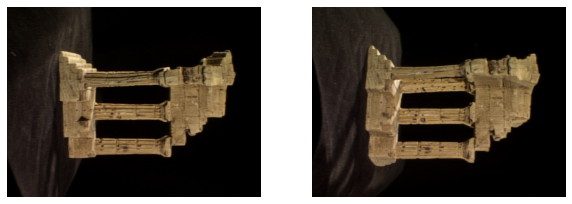

In [2]:
f = open('templeSparseRing/templeSR_par.txt')
assert f is not None

n = int(f.readline())

# information of the first image
l = f.readline().split()
im1_fn = l[0]
K1 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R1 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t1 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

# information of the second image
l = f.readline().split()
im2_fn = l[0]
K2 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R2 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t2 = np.array([float(i) for i in l[19:22]]).reshape((3,1))
P1 = K1 @ np.hstack((R1,t1)) #P = K*[R|t]
P2 = K2 @ np.hstack((R2,t2)) #P = K*[R|t]

#f.close()

img1 = cv.imread('templeSparseRing/templeSR0001.png',cv.IMREAD_COLOR)
assert img1 is not None

img2 = cv.imread('templeSparseRing/templeSR0002.png',cv.IMREAD_COLOR)
assert img1 is not None

fig, ax = plt.subplots(1,2,figsize=(10,5))

im1 = cv.cvtColor(img1,cv.COLOR_BGR2RGB)
im2 = cv.cvtColor(img2,cv.COLOR_BGR2RGB)

ax[0].imshow(im1)
ax[1].imshow(im2)

ax[0].axis('off')
ax[1].axis('off')

plt.show()


### Q1

In [3]:
# Finding SIFT features and Flann-based matching them
sift = cv.SIFT_create()
kp1, decs1 = sift.detectAndCompute(img1, None)
kp2, decs2 = sift.detectAndCompute(img2, None)

FLANN_INDEX_KDTREE = 0
indexParams  = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
searchParams = dict(checks = 50)

flann   = cv.FlannBasedMatcher(indexParams, searchParams)
matches = flann.knnMatch(decs1, decs2, k = 2)

good = []
pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.7 * n.distance:
        good.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

pts1 = np.array(pts1)
pts2 = np.array(pts2)

### Q2

In [4]:
# Calculating F, E matrices
F, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)
E = K2.T @ F @ K1

In [5]:
# fundamental matrix
F

array([[ 1.49034037e-06,  1.44154168e-05, -2.53948320e-02],
       [-8.25788252e-06,  8.67005344e-08,  4.00767127e-03],
       [ 2.27526901e-02, -7.28270380e-03,  1.00000000e+00]])

In [6]:
# essential matrix
E

array([[ 3.44509489e+00,  3.34434549e+01, -3.25145725e+01],
       [-1.91581088e+01,  2.01870994e-01,  2.33852108e+00],
       [ 3.21786978e+01, -4.43004055e+00, -6.22266684e-03]])

### Q3

In [7]:
# recovering the pose of the second camera W.R.T the first
retval, R, t, mask = cv.recoverPose(E, pts1, pts2, K1)

In [16]:
R

array([[ 0.99735986, -0.06955966,  0.02085083],
       [ 0.06147285,  0.96159443,  0.26750185],
       [-0.03865738, -0.26551385,  0.96333172]])

In [17]:
t

array([[-0.06179206],
       [-0.86049654],
       [-0.50569501]])

### Q4

In [13]:
# compute camera matrix p2
R2 = R1 @ R
t2 = R1 @ t

R_t_1 = np.concatenate((R1, t1), axis=1)
R_t_2 = np.concatenate((R2, t2), axis=1)

P2 = K2 @ R_t_2

In [18]:
P2

array([[ 1.58524669e+02,  1.53324446e+03, -1.64453374e+02,
        -9.53099575e+02],
       [ 1.53407871e+03, -1.25194936e+02, -1.42282633e+02,
         4.27897189e+01],
       [ 7.55162306e-02,  8.27859886e-02, -9.93702057e-01,
         6.49896959e-01]])

### Q5

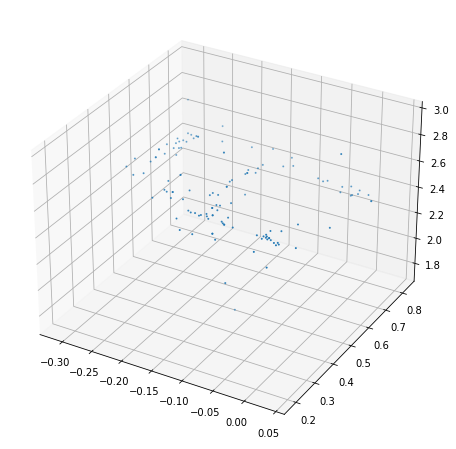

In [15]:
# finding 3D point locations and plotting
points4D = cv.triangulatePoints(P1, P2, pts1.T, pts2.T)
points4D /= points4D[3,:]
X = points4D[0,:]
Y = points4D[1,:]
Z = points4D[2,:]

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection ='3d')
ax.scatter(X, Y, Z, s = 1, cmap = 'gray')
plt.show()